In [1]:
import pip
pip.main(['install', 'scikit-image'])

  Running setup.py bdist_wheel for toolz: started
  Running setup.py bdist_wheel for toolz: finished with status 'done'
  Stored in directory: /home/user/.cache/pip/wheels/b0/84/bf/7089262387e8ea60bdefb1fdb84d2ee99427f6d09c9c7ba37d
Successfully built toolz


You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


0

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

IMAGES_DIR = "/mnt/spin6TB/dirkgr/images"
IMAGES_DIR = "/Users/marvin/Downloads/images"
IMAGES_DIR = "/data/images"
MAX_IMAGE_SIZE = (500, 500)
INPUT_SIZE = (MAX_IMAGE_SIZE[0], MAX_IMAGE_SIZE[1])

BATCH_SIZE = 8

In [16]:
import os
def allImageFilenames(directory):
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.endswith(".jpg"):
                yield os.path.join(root, f)

import skimage.io
def allRawImages(filenames):
    for filename in filenames:
        try:
            image = skimage.io.imread(filename)
            if image.shape[0] > MAX_IMAGE_SIZE[0]:
                raise ValueError("Image %s too big: %r" % (filename, image.shape))
            if image.shape[1] > MAX_IMAGE_SIZE[1]:
                raise ValueError("Image %s too big: %r" % (filename, image.shape))
            yield image
        except ValueError:
            print("Could not load image %s; skipping" % filename)
        
import skimage.util
def padImage(image):
    widthFactor = MAX_IMAGE_SIZE[0] - image.shape[0]
    heightFactor = MAX_IMAGE_SIZE[1] - image.shape[1]
    padValues = (
        tuple(map(int, (widthFactor / 2, widthFactor / 2 + widthFactor % 2))),
        tuple(map(int, (heightFactor / 2, heightFactor / 2 + heightFactor % 2))),
        (0, 0)
    )
    result = skimage.util.pad(image, padValues, 'constant', constant_values=0)
    return result

def floatImage(image):
    return skimage.util.img_as_float(image)

import numpy
def axisFormatToKeras(image):
    return numpy.moveaxis(image, 2, 0)
def axisFormatFromKeras(image):
    return numpy.moveaxis(image, 0, 2)

filenames = list(allImageFilenames(IMAGES_DIR))
TRAIN_VALIDATE_TEST_FRACTIONS = (0.7, 0.2, 0.1)
cutoffs = (
    int(len(filenames) * TRAIN_VALIDATE_TEST_FRACTIONS[0]),
    int(len(filenames) * TRAIN_VALIDATE_TEST_FRACTIONS[0] + TRAIN_VALIDATE_TEST_FRACTIONS[1])
)
filenames_train = filenames[:cutoffs[0]]
filenames_validate = filenames[cutoffs[0]:cutoffs[1]]
filenames_test = filenames[cutoffs[1]:]

def makeData(filenames):
    for rawImage in allRawImages(filenames):
        padded = floatImage(padImage(rawImage))
        yield map(axisFormatToKeras, (padded, padded))
        
def loopInfinitely(generatorGenerator):
    while True:
        for item in generatorGenerator():
            yield item
            
def makeInfiniteDataBatches(filenames):
    def makeGeneratorFromBeginning():
        return makeData(filenames)
    generator = loopInfinitely(makeGeneratorFromBeginning)
    accumulator = []
    for item in generator:
        accumulator.append(item)
        if len(accumulator) >= BATCH_SIZE:
            # accumulator is now a list of (input, label) tuples
            accumulator = zip(*accumulator)
            # accumulator is now a list of length 2, like this: [(input1, input2, ...), (label1, label2, ...)]
            yield map(numpy.stack, accumulator)
            accumulator = []
        
train = makeInfiniteDataBatches(filenames_train)
validate = makeInfiniteDataBatches(filenames_validate)
test = makeInfiniteDataBatches(filenames_test)

In [17]:
from keras.models import Sequential, Model
from keras.layers import Activation, Input
from keras.layers.convolutional import Convolution2D, UpSampling2D

input_image = Input(shape = (3,) + INPUT_SIZE)

encoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same')(input_image)
encoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same')(encoded)
encoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same', subsample = (2, 2))(encoded)
encoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same')(encoded)
encoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same')(encoded)
encoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same', subsample = (2, 2))(encoded)
encoded = Convolution2D(3, 5, 5, activation="relu", border_mode='same')(encoded)

decoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same')(encoded)
decoded = UpSampling2D()(decoded)
decoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same')(decoded)
decoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same')(decoded)
decoded = UpSampling2D()(decoded)
decoded = Convolution2D(32, 5, 5, activation="relu", border_mode='same')(decoded)
decoded = Convolution2D(3, 5, 5, activation="relu", border_mode='same')(decoded)
decoded = Activation("tanh")(decoded)  # make sure all outputs are between 0 and 1

autoencoder = Model(input_image, output=decoded)
autoencoder.summary()
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

encoder = Model(input_image, output=encoded)
encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 3, 500, 500)   0                                            
____________________________________________________________________________________________________
convolution2d_91 (Convolution2D) (None, 32, 500, 500)  2432        input_5[0][0]                    
____________________________________________________________________________________________________
convolution2d_92 (Convolution2D) (None, 32, 500, 500)  25632       convolution2d_91[0][0]           
____________________________________________________________________________________________________
convolution2d_93 (Convolution2D) (None, 32, 250, 250)  25632       convolution2d_92[0][0]           
___________________________________________________________________________________________

.

Iteration 0
Train loss: 0.162252	Test loss: 0.135788


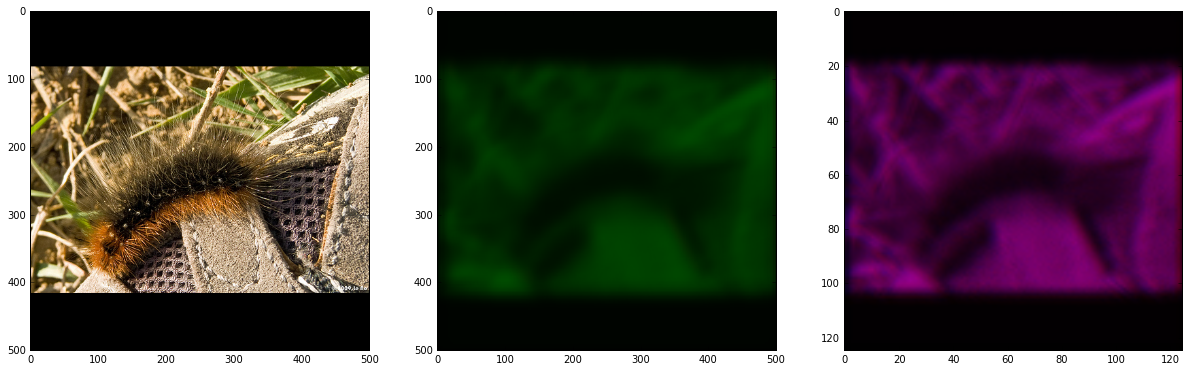

Original: 0.00000	Scikit: 0.14302


................

Iteration 16
Train loss: 0.026863	Test loss: 0.027690


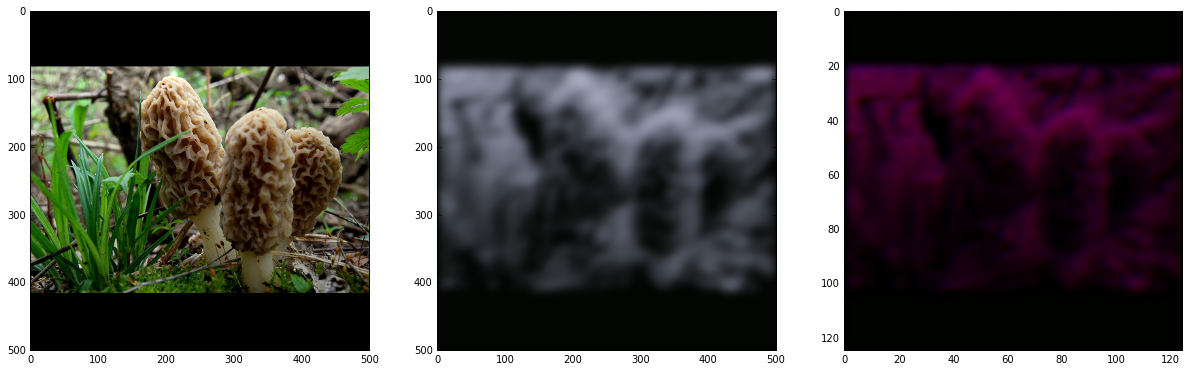

Original: 0.00000	Scikit: 0.02007


................

Iteration 32
Train loss: 0.018679	Test loss: 0.013429


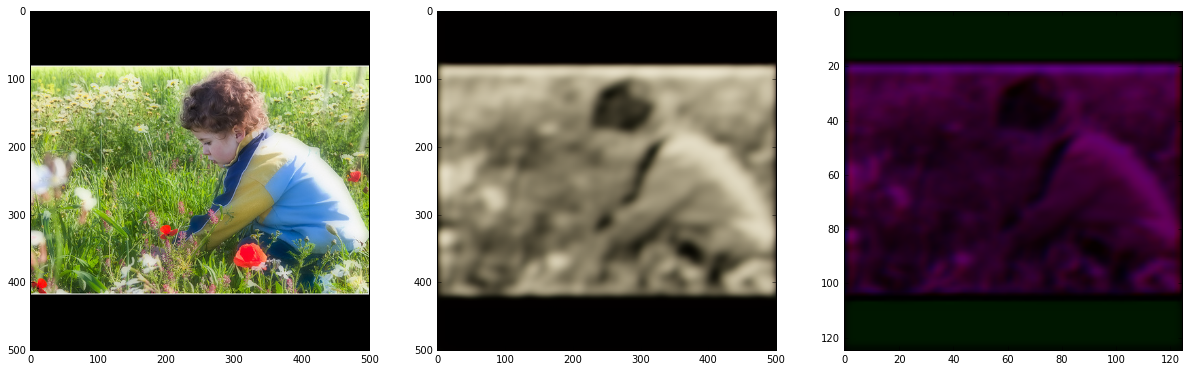

Original: 0.00000	Scikit: 0.01976


................

Iteration 48
Train loss: 0.020087	Test loss: 0.013881


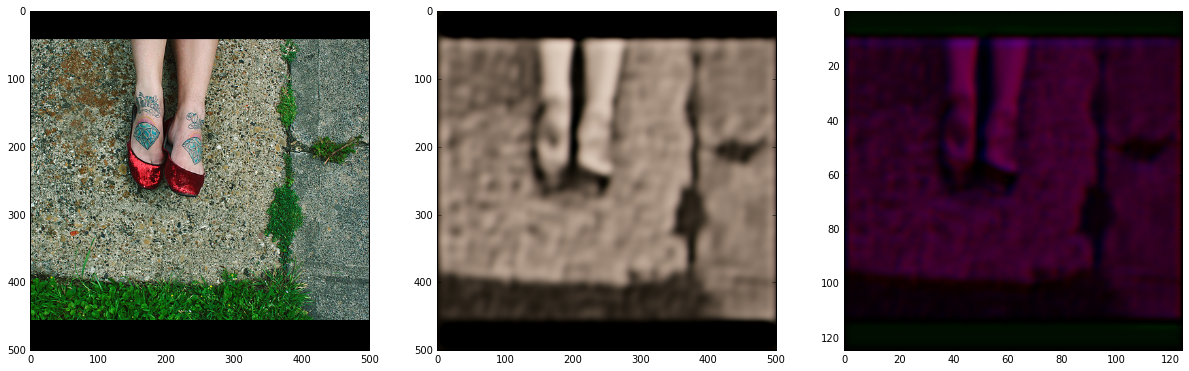

Original: 0.00000	Scikit: 0.02353


...........

In [ ]:
def mse(a, b):
    return ((a - b) ** 2).mean(axis = None)

for i in range(10240):
    x_train, y_train = next(train)
    (train_loss, train_acc) = autoencoder.train_on_batch(x_train, y_train)
    print('.', end="")

    if i % 16 == 0:
        print("\n")
        x_test, y_test = next(test)
        (test_loss, test_acc) = autoencoder.test_on_batch(x_test, y_test)

        print("Iteration %i\nTrain loss: %f\tTest loss: %f" % (i, train_loss, test_loss))

        prediction = autoencoder.predict_on_batch(x_test)
        encoded = encoder.predict_on_batch(x_test)

        firstOriginal = y_test[0]
        firstOriginal = axisFormatFromKeras(firstOriginal)

        firstDecoded = prediction[0]
        firstDecoded = axisFormatFromKeras(firstDecoded)

        firstEncoded = encoded[0]
        firstEncoded = axisFormatFromKeras(firstEncoded)
        
        f, (originalFig, decodedFig, encodedFig) = plt.subplots(1, 3)
        f.set_figheight(700/92)
        f.set_figwidth(1900/92)
        originalFig.imshow(firstOriginal)
        decodedFig.imshow(firstDecoded)
        encodedFig.imshow(firstEncoded)
        plt.show()
        
        print(
            "Original: %.5f\tDecoded: %.5f" % (
                mse(firstOriginal, firstOriginal),
                mse(firstOriginal, firstDecoded)))
        print("\n")

In [15]:
model.evaluate_generator(test, 256)

#plt.imshow(scaledImage)
#plt.imshow(paddedImage)

KeyboardInterrupt: 

In [20]:
(scaledDownBatch, originalBatch) = test.next() 
resultBatch = model.predict_on_batch(scaledDownBatch)

firstResult = resultBatch[0]
firstResult = axisFormatFromKeras(firstResult)

firstOriginal = originalBatch[0]
firstOriginal = axisFormatFromKeras(firstOriginal)

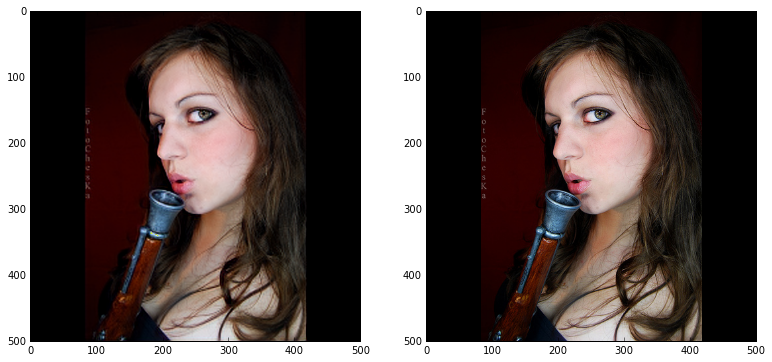

In [21]:
f, (resultFig, originalFig) = plt.subplots(1, 2)
f.set_figheight(600/92)
f.set_figwidth(1200/92)
resultFig.imshow(firstResult)
originalFig.imshow(firstOriginal)